# Notebook for free speech feature extraction 

In [1]:
import json
import math
import nltk
import torch
import string
import requests
import itertools
import numpy as np
import pandas as pd
import networkx as nx
from scipy import stats
import tensorflow as tf
from scipy import spatial
from nltk.util import ngrams
import tensorflow_hub as hub
from textblob import TextBlob
import matplotlib.pyplot as plt
from scipy.stats import linregress
from statistics import mean, stdev
from pycorenlp import StanfordCoreNLP
from gensim.models import KeyedVectors
from transformers import BertTokenizer, BertModel
from nltk.tokenize import sent_tokenize, word_tokenize
from transformers import GPT2Tokenizer, GPT2LMHeadModel

# only if it has not been downloaded, uncomment:
# nltk.download('averaged_perceptron_tagger')

In [2]:
# read in the data 
# COLUMNS: 
# - FILE (a unique designator), 
# - TRANSCRIPT (human transcribed transcript)
# - GROUP (1 = control, 2 = aMCI, 3 = AD)

free_speech = pd.read_excel('Free_Speech.xlsx')

# change the column names to match above
#free_speech = free_speech.rename(columns={'Human Transcript':'TRANSCRIPT'})
#free_speech = free_speech.dropna(subset=['TRANSCRIPT'])

**NOTE**: if there is any editing of the transcripts you want to do, I would do it before running the rest of the cells. For instance, removing annotator comments like {unsure of this word} or whatever oddities might show up in your transcripts

### token and type count

In [13]:
free_speech['participant_wc'] = free_speech.apply(lambda row: len([x for x in row['TRANSCRIPT'].split() if x != '']), axis=1)
free_speech['participant_types'] = free_speech.apply(lambda row: len(set([x for x in row['TRANSCRIPT'].split() if x != ''])), axis=1)

### type token ratio

In [14]:
type_token_ratio = []

for index, row in free_speech.iterrows():
    type_token_ratio.append(row['participant_types']/row['participant_wc'])
    
free_speech['participant_type_token_ratio'] = type_token_ratio

### brunet's index

In [15]:
brunets_index = []

for index, row in free_speech.iterrows():
    # log(wc**types**-0.165) = (types**-0.165)*log(wc)
    brunets_index.append(row['participant_types']**(-0.165)*math.log(row['participant_wc']))

free_speech['participant_brunets_index'] = brunets_index

### count of ums ahs etc. 

In [16]:
participant_ums_or_ahs = []
participant_ums_or_ahs_freq = []

for utterance, wc in zip(free_speech.TRANSCRIPT, free_speech.participant_wc):
    total_ums_ahs = 0
    for word in utterance.split():
        # can include more here!
        if word.lower() == 'um' or word.lower() == 'ah' or word.lower() == 'uh':
            total_ums_ahs += 1

    participant_ums_or_ahs.append(total_ums_ahs)
    participant_ums_or_ahs_freq.append(total_ums_ahs/wc)
    
free_speech['participant_ums_or_ahs_count'] = participant_ums_or_ahs
free_speech['participant_ums_or_ahs_freq'] = participant_ums_or_ahs_freq


### sentiment of all sentences per participant

In [19]:
participant_mean_sentiment = []
participant_max_sentiment = []
participant_min_sentiment = []
participant_stdv_sentiment = []

for transcript in free_speech.TRANSCRIPT:
    blob = TextBlob(transcript)
    all_sentiments = [sentence.sentiment.polarity for sentence in blob.sentences]
    participant_mean_sentiment.append(mean(all_sentiments))
    participant_max_sentiment.append(max(all_sentiments))
    participant_min_sentiment.append(min(all_sentiments))
    try:
        participant_stdv_sentiment.append(stdev(all_sentiments))
    except:
        participant_stdv_sentiment.append(0)

free_speech['participant_mean_sentiment'] = participant_mean_sentiment
free_speech['participant_max_sentiment'] = participant_max_sentiment
free_speech['participant_min_sentiment'] = participant_min_sentiment
free_speech['participant_stdv_sentiment'] = participant_stdv_sentiment

### parts of speech frequencies per participant + content density

In [20]:
participant_noun_freq = []
participant_determiner_freq = []
participant_preposition_freq = []
participant_base_verb_freq = []
participant_pasttense_verb_freq = []
participant_gerund_presentparticiple_verb_freq = []
participant_pastparticiple_verb_freq = []
participant_non3rdpersonsingularpresent_verb_freq = []
participant_3rdpersonsingularpresent_verb_freq = []
participant_TOTAL_verb_freq = []
participant_to_freq = []
participant_adverb_freq = []
participant_adjective_freq = []
participant_modal_freq = []
participant_coordinating_conjunctions_freq = []
participant_cardinals_freq = []
participant_particle_freq = []
participant_personal_pronoun_freq = []
participant_wh_adverbs_freq = []
participant_possessive_pronoun_freq = []
participant_wh_determiner_freq = []
participant_predeterminer_freq = []
participant_interjection_freq = []
participant_existential_there_freq = []
participant_wh_pronoun_freq = []
participant_content_density = []

for transcript, wc in zip(free_speech.TRANSCRIPT, free_speech.participant_wc):
    blob = TextBlob(transcript)
    nouns = 0
    determiners = 0
    prepositions = 0
    base_verbs = 0
    pasttense_verbs = 0
    verb_gerund_presentparticiple = 0
    verb_pastparticiple = 0
    verb_non3rdpersonsingularpresent = 0
    verb_3rdpersonsingularpresent = 0
    tos = 0
    adverbs = 0
    adjectives = 0
    modals = 0
    coordinating_conjunctions = 0
    cardinals = 0
    particles = 0
    personal_pronouns = 0
    wh_adverbs = 0
    possessive_pronouns = 0
    wh_determiners = 0
    predeterminers = 0
    interjections = 0
    existential_theres = 0
    wh_pronouns = 0
    
    for word, tag in blob.tags:
        #all nouns grouped together: singular, plural, proper singular, proper plural 
        if tag == 'NN' or tag == 'NNS' or tag == 'NNP' or tag == 'NNPS':
            nouns += 1
        elif tag == 'DT':
            determiners += 1
        elif tag == 'IN':
            prepositions += 1
        elif tag == 'VB':
            base_verbs +=1
        elif tag == 'VBD':
            pasttense_verbs += 1
        elif tag == 'VBG':
            verb_gerund_presentparticiple += 1
        elif tag == 'VBN':
            verb_pastparticiple += 1
        elif tag == 'VBP':
            verb_non3rdpersonsingularpresent += 1
        elif tag == 'VBZ':
            verb_3rdpersonsingularpresent += 1
        elif tag == 'TO':
            tos += 1
        #all adverbs grouped together: normal, comparative, superlative
        elif tag == 'RB' or tag == 'RBR' or tag == 'RBS':
            adverbs += 1
        #all adjectives grouped together: normal, comparative, superlative
        elif tag == 'JJ' or tag == 'JJR' or tag == 'JJS':
            adjectives += 1
        elif tag == 'MD':
            modals += 1
        elif tag == 'CC':
            coordinating_conjunctions += 1
        elif tag == 'RP':
            particles += 1
        elif tag == 'CD':
            cardinals += 1
        elif tag == 'PRP':
            personal_pronouns += 1
        #when
        elif tag == 'WRB':
            wh_adverbs += 1  
        elif tag == 'PRP$':
            possessive_pronouns += 1
        #that
        elif tag == 'WDT':
            wh_determiners += 1
        elif tag == 'PDT':
            predeterminers += 1
        elif tag == 'UH':
            interjections += 1
        elif tag == 'EX':
            existential_theres += 1
        #who, what, whose
        elif tag == 'WP' or tag == 'WP$':
            wh_pronouns += 1
            
    total_verbs = base_verbs+pasttense_verbs+verb_gerund_presentparticiple+verb_pastparticiple+verb_non3rdpersonsingularpresent+verb_3rdpersonsingularpresent
    participant_noun_freq.append(nouns/wc)
    participant_determiner_freq.append(determiners/wc)
    participant_preposition_freq.append(prepositions/wc)
    participant_base_verb_freq.append(base_verbs/wc)
    participant_pasttense_verb_freq.append(pasttense_verbs/wc)
    participant_gerund_presentparticiple_verb_freq.append(verb_gerund_presentparticiple/wc)
    participant_pastparticiple_verb_freq.append(verb_pastparticiple/wc)
    participant_non3rdpersonsingularpresent_verb_freq.append(verb_non3rdpersonsingularpresent/wc)
    participant_3rdpersonsingularpresent_verb_freq.append(verb_3rdpersonsingularpresent/wc)
    participant_TOTAL_verb_freq.append(total_verbs/wc)
    participant_to_freq.append(tos/wc)
    participant_adverb_freq.append(adverbs/wc)
    participant_adjective_freq.append(adjectives/wc)
    participant_modal_freq.append(modals/wc)
    participant_coordinating_conjunctions_freq.append(coordinating_conjunctions/wc)
    participant_cardinals_freq.append(cardinals/wc)
    participant_particle_freq.append(particles/wc)
    participant_personal_pronoun_freq.append(personal_pronouns/wc)
    participant_wh_adverbs_freq.append(wh_adverbs/wc)
    participant_possessive_pronoun_freq.append(possessive_pronouns/wc)
    participant_wh_determiner_freq.append(wh_determiners/wc)
    participant_predeterminer_freq.append(predeterminers/wc)
    participant_interjection_freq.append(interjections/wc)
    participant_existential_there_freq.append(existential_theres/wc)
    participant_wh_pronoun_freq.append(wh_pronouns/wc)
    participant_content_density.append((total_verbs+nouns+adjectives+adverbs)/wc)
    
    
free_speech['participant_noun_freq'] = participant_noun_freq
free_speech['participant_determiner_freq'] = participant_determiner_freq
free_speech['participant_preposition_freq'] = participant_preposition_freq
free_speech['participant_base_verb_freq'] = participant_base_verb_freq
free_speech['participant_pasttense_verb_freq'] = participant_pasttense_verb_freq
free_speech['participant_gerund_presentparticiple_verb_freq'] = participant_gerund_presentparticiple_verb_freq
free_speech['participant_pastparticiple_verb_freq'] = participant_pastparticiple_verb_freq
free_speech['participant_non3rdpersonsingularpresent_verb_freq'] = participant_non3rdpersonsingularpresent_verb_freq
free_speech['participant_3rdpersonsingularpresent_verb_freq'] = participant_3rdpersonsingularpresent_verb_freq
free_speech['participant_TOTAL_verb_freq'] = participant_TOTAL_verb_freq
free_speech['participant_to_freq'] = participant_to_freq
free_speech['participant_adverb_freq'] = participant_adverb_freq
free_speech['participant_adjective_freq'] = participant_adjective_freq
free_speech['participant_modal_freq'] = participant_modal_freq
free_speech['participant_coordinating_conjunctions_freq'] = participant_coordinating_conjunctions_freq
free_speech['participant_cardinals_freq'] = participant_cardinals_freq
free_speech['participant_particle_freq'] = participant_particle_freq
free_speech['participant_personal_pronoun_freq'] = participant_personal_pronoun_freq
free_speech['participant_wh_adverbs_freq'] = participant_wh_adverbs_freq
free_speech['participant_possessive_pronoun_freq'] = participant_possessive_pronoun_freq
free_speech['participant_wh_determiner_freq'] = participant_wh_determiner_freq
free_speech['participant_predeterminer_freq'] = participant_predeterminer_freq
free_speech['participant_interjection_freq'] = participant_interjection_freq
free_speech['participant_existential_there_freq'] = participant_existential_there_freq
free_speech['participant_wh_pronoun_freq'] = participant_wh_pronoun_freq
free_speech['participant_content_density'] = participant_content_density

### coherence features

#### First, load the embeddings you want to compute (comment out the ones you are not currently computing for memory purposes)

In [ ]:
## Comment out anything you don't want to load for memory purposes! ##

# W2V Don't Count, Predict! embeddings (download from https://zenodo.org/record/2635544#.YqpI7BPMJQI)
dcp_embeddings = {}
input_file = open('EN-wform.w.5.cbow.neg10.400.subsmpl.txt', 'r') 
for line in input_file:
    tokens = line.split('\t')
    tokens[-1] = tokens[-1].strip()
    for i in range(1, len(tokens)):
        tokens[i] = float(tokens[i])
    dcp_embeddings[tokens[0]] = tokens[1:-1]
    

# W2V Google News embeddings (download from https://code.google.com/archive/p/word2vec/)
w2v_embeddings = KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300.bin', binary=True)
   

# GloVE embeddings (download from https://nlp.stanford.edu/projects/glove/)
glove_embeddings = {}
with open("glove.42B.300d.txt", 'r') as f:
    for line in f:
        values = line.split()
        word = values[0]
        vector = [float(x) for x in values[1:]]
        glove_embeddings[word] = vector
# USE model
use_module_url = "https://tfhub.dev/google/universal-sentence-encoder/4" 
use_model = hub.load(use_module_url)

# ELMo model
elmo_model_url = "https://tfhub.dev/google/elmo/2"
elmo_model = hub.load(elmo_model_url).signatures["default"]

# BERT model
bert_tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
bert_model = BertModel.from_pretrained('bert-base-uncased', output_hidden_states = True)
bert_model.eval()

again, for memory purposes you cand delete the models you download AFTER you use them!

In [135]:
#del dcp_embeddings

### functions for coherence computations

In [144]:
def embed(text, embedding_type):
    '''
    returns a single embedding (inter) or a list of embeddings (intra)
    for a specified string and embedding_type
    '''
    
    # universal sentence encoder
    if embedding_type == 'USE_inter':
        return use_model([text])[0]
    
    if embedding_type == 'USE_intra':
        embeddings = []
        for word in text.split():
            embeddings.append(use_model([word])[0])
        return embeddings
    
    # embeddings from language models - interwindow
    elif embedding_type == 'ELMo_inter':
        return elmo_model(tf.constant([text]))["default"].numpy()[0]
    
    # embeddings from language models - intrawindow
    elif embedding_type == 'ELMo_intra':
        embeddings_tensor = elmo_model(tf.constant([text]))
        word_embeddings = embeddings_tensor['word_emb'][0]
        word_embeddings_unpacked = [x.numpy() for x in tf.unstack(word_embeddings)] 
        return word_embeddings_unpacked
    
    # BERT interwindow
    elif embedding_type == 'BERT_inter':
        # interwindow
        tokenized_text = bert_tokenizer.encode(text)
        # convert indexed tokens in a PyTorch tensor
        input_ids = torch.tensor(tokenized_text).unsqueeze(0)
        # run the input tensor through the BertModel
        # see text in above cell for what is contained in outputs variable
        outputs = bert_model(input_ids)
        # get the last_hidden_state
        last_hidden_state = outputs[0]
        # last hidden state is dimension (batch_size, sequence_length, hidden_size)
        # we have one batch so grab this single batch - this_batch is a tensor for each token in tokenized_text
        this_batch = last_hidden_state[0]
        #now get the 768 dimension vector for the CLS token (the first in the list) 
        cls_vector = this_batch[0].detach().numpy()
        return cls_vector
    
    # BERT intrawindow
    elif embedding_type == 'BERT_intra':
        marked_text = "[CLS] " + text + " [SEP]"
        # Tokenize our sentence with the BERT tokenizer.
        tokenized_text = bert_tokenizer.tokenize(marked_text)
        indexed_tokens = bert_tokenizer.convert_tokens_to_ids(tokenized_text)
        tokens_tensor = torch.tensor([indexed_tokens])
        with torch.no_grad():
            outputs = bert_model(tokens_tensor)
            # Evaluating the model will return a different number of objects based on 
            # how it's  configured in the `from_pretrained` call earlier. In this case, 
            # becase we set `output_hidden_states = True`, the third item will be the 
            # hidden states from all layers. See the documentation for more details:
            # https://huggingface.co/transformers/model_doc/bert.html#bertmodel
            hidden_states = outputs[2]
            token_embeddings = torch.stack(hidden_states, dim=0)
            token_embeddings = torch.squeeze(token_embeddings, dim=1)
            # Swap dimensions 0 and 1 so we can loop through the embeddings
            token_embeddings = token_embeddings.permute(1,0,2)
            # Stores the token vectors, with shape [N tokens x 768]
            token_vecs_sum = []
            # For each token in the sentence...
            for token in token_embeddings[1:-1]:
                # Sum the vectors from the last four layers.
                sum_vec = torch.sum(token[-4:], dim=0)
                # Use `sum_vec` to represent `token`.
                token_vecs_sum.append(sum_vec)
        return token_vecs_sum
             
    # word2vec: don't count, predict! 
    elif embedding_type == 'DCP_inter': 
        words = str(text).translate(str.maketrans("", "", string.punctuation)).lower()
        vecs = []
        for word in words.split():
            if word in dcp_embeddings:
                vecs.append(dcp_embeddings[word])
        if len(vecs) == 0:
            return None
        else:
            return vector_sum(vecs)
           
    # word2vec: don't count, predict! 
    elif embedding_type == 'DCP_intra': 
        words = str(text).translate(str.maketrans("", "", string.punctuation)).lower()
        vecs = []
        for word in words.split():
            if word in dcp_embeddings:
                vecs.append(dcp_embeddings[word])
        if len(vecs) == 0:
            return None
        else:
            return vecs
            
    # word2vec: google news 
    elif embedding_type == 'W2V_inter':
        words = str(text).translate(str.maketrans("", "", string.punctuation)).lower()
        vecs = []
        for word in words.split():
            if word in w2v_embeddings.key_to_index:
                vecs.append(w2v_embeddings[word])
        if len(vecs) == 0:
            return None
        else:
            return vector_sum(vecs)
   
    # word2vec: google news 
    elif embedding_type == 'W2V_intra':
        words = str(text).translate(str.maketrans("", "", string.punctuation)).lower()
        vecs = []
        for word in words.split():
            if word in w2v_embeddings.key_to_index:
                vecs.append(w2v_embeddings[word])
        if len(vecs) == 0:
            return None
        else:
            return vecs
            
    # GloVe
    elif embedding_type == 'GloVe_inter':
        words = str(text).translate(str.maketrans("", "", string.punctuation)).lower()
        vecs = []
        for word in words.split():
            if word in glove_embeddings:
                vecs.append(glove_embeddings[word])
        if len(vecs) == 0:
            return None
        else:
            return vector_sum(vecs)
   
    # GloVe
    elif embedding_type == 'GloVe_intra':
        words = str(text).translate(str.maketrans("", "", string.punctuation)).lower()
        vecs = []
        for word in words.split():
            if word in glove_embeddings:
                vecs.append(glove_embeddings[word])
        if len(vecs) == 0:
            return None
        else:
            return vecs

    else:
        print('Incorrect embedding type')
        return None
        
        
def vector_sum(vectors):
    '''
    given a list of vectors for a sentence, return the sum of all vectors
    this is used to create ngram+ embeddings for non-contextualized embedding types
    '''
    n = len(vectors)
    d = len(vectors[0])

    #create an array initialized to 0 of the same length of the word embeddings
    s = [0 for i in range(d)]

    #add each word embedding to the zero vector
    for vector in vectors:
        s = s + np.array(vector)

    return list(s)


def get_intra_window_cosines(text, embedding_type):
    '''
    iterate through a window comparing each word to each other word
    '''
    
    all_embeddings = embed(text, embedding_type+'_intra')
    
    if all_embeddings:
        if len(all_embeddings) < 2:
            return None

        all_cosines = []
        for a, b in itertools.combinations(all_embeddings, 2):
            cos = 1 - spatial.distance.cosine(a, b)
            all_cosines.append(cos)

        return all_cosines
    
    else:
        return None


def get_inter_window_cosine(text1, text2, embedding_type):
    
    e1 = embed(text1, embedding_type+'_inter')
    e2 = embed(text2, embedding_type+'_inter')
    if embedding_type == 'USE' or embedding_type == 'ELMo' or embedding_type == 'BERT':
        return 1 - spatial.distance.cosine(e1, e2)

    else:
        if e1 and e2:
            return 1 - spatial.distance.cosine(e1, e2)
        else:
            return None
    
def get_ngrams(text, n):
    '''
    return a list of n-grams
    '''

    n_grams = ngrams(word_tokenize(text), n)
    
    return [' '.join(grams) for grams in n_grams]


def get_slope(nums):
    '''
    compute the slope of a list of cosines
    '''
    x = range(len(nums))
    y = nums

    slope, intercept, r_value, p_value, std_err = linregress(x, y)

    return slope

### within window coherence (intrawindow)

In [ ]:
embedding = 'DCP' # iteratively swap out for DCP, GloVe, ELMo, W2V, USE, BERT

for window in [3, 4, 5, 6, 7, 8, 'sentence']:

    print(embedding, window)
    
    mean_coherence = []
    std_coherence = []
    min_coherence = []
    max_coherence = []

    for transcript in free_speech.TRANSCRIPT:
        
        ## CAN OPTIONALLY REMOVE STOP WORDS HERE ##
        
        ## ALSO I DO TEXT PREPROCESSING HERE! ##
        ## remove all puncutation for windows in [3,8] BUT
        ## leave end of sentence markers for the sentence-windows 
                        
        if window == 'sentence':
            n_grams = sent_tokenize(all_utterances)
        else:
            n_grams = get_ngrams(all_utterances, window)
        
        cosines = []
        for i in range(len(n_grams)):
            res_list = get_intra_window_cosines(n_grams[i], embedding)
            if res_list:
                cosines.append(np.array(res_list).mean())

        mean_coherence.append(np.array(cosines).mean())
        std_coherence.append(np.array(cosines).std())
        min_coherence.append(min(cosines))
        max_coherence.append(max(cosines))

    free_speech[f'mean_intrawindow_coherence_{window}_{embedding}'] = mean_coherence
    free_speech[f'std_intrawindow_coherence_{window}_{embedding}'] = std_coherence
    free_speech[f'min_intrawindow_coherence_{window}_{embedding}'] = min_coherence
    free_speech[f'max_intrawindow_coherence_{window}_{embedding}'] = max_coherence
    

### between window coherence (interwindow) 

In [ ]:
embedding = 'DCP' # iteratively swap out for DCP, GloVe, ELMo, W2V, USE, BERT

for window in [3, 4, 5, 6, 7, 8, 'sentence']:
    
    print(embedding, window)

    mean_coherence = []
    std_coherence = []
    min_coherence = []
    max_coherence = []
    slope_coherence = []

    for transcript in free_speech.TRANSCRIPT:
        
        ## CAN OPTIONALLY REMOVE STOP WORDS HERE ##
        
        ## ALSO I DO TEXT PREPROCESSING HERE! ##
        ## remove all puncutation for windows in [3,8] BUT
        ## leave end of sentence markers for the sentence-windows         
        
        if window == 'sentence':
            n_grams = sent_tokenize(all_utterances)
            cosines = []
            for i in range(len(n_grams)-1):
                res = get_inter_window_cosine(n_grams[i], n_grams[i+1], embedding)
                if res:
                    cosines.append(res)  
                    
        else:
            n_grams = get_ngrams(all_utterances, window)
            cosines = []
            for i in range(len(n_grams)-window):
                res = get_inter_window_cosine(n_grams[i], n_grams[i+window], embedding)
                if res:
                    cosines.append(res)  
                    
        if len(cosines) == 0:
            mean_coherence.append(np.nan)
            std_coherence.append(np.nan)
            min_coherence.append(np.nan)
            max_coherence.append(np.nan)
        else:
            mean_coherence.append(np.array(cosines).mean())
            std_coherence.append(np.array(cosines).std())
            min_coherence.append(min(cosines))
            max_coherence.append(max(cosines))
        
        if window == 'sentence':
            slope_cosines = []
            for i in range(len(n_grams)-1):
                # compare each window to the first window and calculate the slope
                res = get_inter_window_cosine(n_grams[0], n_grams[i+1], embedding)
                if res:
                    slope_cosines.append(res)  
            if len(slope_cosines) == 0:
                slope_coherence.append(np.nan)
            else:
                slope_coherence.append(get_slope(slope_cosines))

        else:
            slope_cosines = []
            for i in range(len(n_grams)-window):
                # compare each window to the first window and calculate the slope
                res = get_inter_window_cosine(n_grams[0], n_grams[i+window], embedding)
                if res:
                    slope_cosines.append(res)  
            slope_coherence.append(get_slope(slope_cosines))

    free_speech[f'mean_coherence_{window}_{embedding}_interwindow'] = mean_coherence
    free_speech[f'std_coherence_{window}_{embedding}_interwindow'] = std_coherence
    free_speech[f'min_coherence_{window}_{embedding}_interwindow'] = min_coherence
    free_speech[f'max_coherence_{window}_{embedding}_interwindow'] = max_coherence
    free_speech[f'tangentiality_{window}_{embedding}_interwindow'] = slope_coherence


### coherence between interviewer question and ngrams from interviewee responses + tangentiality

In [ ]:
main_question = "<insert interviewer question here>"

embedding = 'DCP' # iteratively swap out for DCP, GloVe, ELMo, W2V, USE, BERT

for window in [3, 4, 5, 6, 7, 8, 'sentence']:
   
    print(embedding, window)
    
    mean_coherence = []
    std_coherence = []
    min_coherence = []
    max_coherence = []
    slope_coherence = []
    
    for transcript in free_speech.TRANSCRIPT:

        ## CAN OPTIONALLY REMOVE STOP WORDS HERE ##
        
        ## ALSO I DO TEXT PREPROCESSING HERE! ##
        ## remove all puncutation for windows in [3,8] BUT
        ## leave end of sentence markers for the sentence-windows     

        cosines = []
        
        if window == 'sentence':
            n_grams = sent_tokenize(all_utterances)
        else:
            n_grams = get_ngrams(all_utterances, window)
            
        for i in range(len(n_grams)):
            cos = get_inter_window_cosine(n_grams[i], main_question, embedding)
            if cos:
                cosines.append(cos)

        mean_coherence.append(np.array(cosines).mean())
        std_coherence.append(np.array(cosines).std())
        min_coherence.append(min(cosines))
        max_coherence.append(max(cosines))
        slope_coherence.append(get_slope(cosines))

    free_speech[f'mean_coherence_to_prompt_{window}_{embedding}'] = mean_coherence
    free_speech[f'std_coherence_to_prompt_{window}_{embedding}'] = std_coherence
    free_speech[f'min_coherence_to_prompt_{window}_{embedding}'] = min_coherence
    free_speech[f'max_coherence_to_prompt_{window}_{embedding}'] = max_coherence
    free_speech[f'tangentiality_to_prompt_{window}_{embedding}'] = slope_coherence


### sentence entropy

In [3]:
# BERT 

## loading this here because they have the same name as the 
## previous (different) BERT tokenizer 

import torch
from transformers import BertTokenizer, BertForMaskedLM

# Load pre-trained model (weights)
with torch.no_grad():
    bert_model = BertForMaskedLM.from_pretrained('bert-large-cased')
    bert_model.eval()
    # Load pre-trained model tokenizer (vocabulary)
    bert_tokenizer = BertTokenizer.from_pretrained('bert-large-cased')
    
def get_BERT_score(sentence):
    tokenize_input = bert_tokenizer.tokenize(sentence)
    tokenize_input = ["[CLS]"]+tokenize_input+["[SEP]"]
    tensor_input = torch.tensor([bert_tokenizer.convert_tokens_to_ids(tokenize_input)])
    with torch.no_grad():
        loss = bert_model(tensor_input, labels=tensor_input)[0]
    return np.exp(loss.detach().numpy())


# GPT 2
with torch.no_grad():
    gpt2_model = GPT2LMHeadModel.from_pretrained('gpt2')
    gpt2_model.eval()
gpt2_tokenizer = GPT2Tokenizer.from_pretrained('gpt2')
 
def get_GPT_score(sentence):
    tokenize_input = gpt2_tokenizer.encode(sentence)
    tensor_input = torch.tensor([tokenize_input])
    loss = gpt2_model(tensor_input, labels=tensor_input)[0]
    return np.exp(loss.detach().numpy())

Some weights of the model checkpoint at bert-large-cased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [ ]:
embedding = 'BERT' # swap out for GPT2

avg_sentence_probabilities = []
min_sentence_probabilities = []
max_sentence_probabilities = []
stdv_sentence_probabilities = []
firstquartile_sentence_probabilities = []
median_sentence_probabilities = []
thirdquartile_sentence_probabilities = []

for utterance in free_speech.TRANSCRIPT:

    all_utterances = utterance.lower()
    
    sentences = sent_tokenize(all_utterances)
    
    sentence_probs = []

    if embedding == 'BERT':
        for text in sentences:
            if len(text.split()) > 2:
                sentence_probs.append(get_BERT_score(text))
                
    elif embedding == 'GPT2':
        for text in sentences:
            if len(text.split()) > 2:
                sentence_probs.append(get_GPT_score(text))
                
    else:
        print('incorrect embedding type')
        break
                
    if len(sentence_probs) > 0:
        firstquartile_sentence_probabilities.append(np.percentile(sentence_probs, 25))
        median_sentence_probabilities.append(np.percentile(sentence_probs, 50))
        thirdquartile_sentence_probabilities.append(np.percentile(sentence_probs, 75))
        avg_sentence_probabilities.append(np.array(sentence_probs).mean())
        min_sentence_probabilities.append(min(sentence_probs))
        max_sentence_probabilities.append(max(sentence_probs))
        stdv_sentence_probabilities.append(np.array(sentence_probs).std())
    else:
        # there were no sentences > 2 words...
        firstquartile_sentence_probabilities.append(np.nan)
        median_sentence_probabilities.append(np.nan)
        thirdquartile_sentence_probabilities.append(np.nan)
        avg_sentence_probabilities.append(np.nan)
        min_sentence_probabilities.append(np.nan)
        max_sentence_probabilities.append(np.nan)
        stdv_sentence_probabilities.append(np.nan)  
        
free_speech[f'mean_sentence_probability_{embedding}'] = avg_sentence_probabilities
free_speech[f'min_sentence_probability_{embedding}'] = min_sentence_probabilities
free_speech[f'max_sentence_probability_{embedding}'] = max_sentence_probabilities
free_speech[f'stdv_sentence_probability_{embedding}'] = stdv_sentence_probabilities
free_speech[f'firstquartile_sentence_probability_{embedding}'] = firstquartile_sentence_probabilities
free_speech[f'median_sentence_probability_{embedding}'] = median_sentence_probabilities
free_speech[f'thirdquartile_sentence_probability_{embedding}'] = thirdquartile_sentence_probabilities


### parse depths of sentences

first download stanford corenlp https://stanfordnlp.github.io/CoreNLP/download.html

then run the server inside the folder:

    export CLASSPATH="`find . -name '*.jar'`"
    java -mx4g -cp "*" edu.stanford.nlp.pipeline.StanfordCoreNLPServer 9000

In [4]:
nlp = StanfordCoreNLP('http://localhost:9000') # or whatever port is chosen when starting the server

all_max_depths = []
    
for utterance in free_speech.TRANSCRIPT:
    
    all_utterances = utterance.lower()
    
    sentences = sent_tokenize(all_utterances)
    
    # for sentence in each utterance
    max_depths = []
    for text in sentences:
        
        out = nlp.annotate(text, properties={
            'annotators': 'parse',
            'outputFormat': 'json'
        })

        try:
            output = json.loads(out)
            parse = output['sentences'][0]['parse'].split('\n')
        except:
            # usually fails when sentence is too long.
            # skip it for now
            # could try an automated punctuator that may break the sentence up
            print('sentence too long: ', text)
            continue
            
        bracket_counter = []
        for line in parse:
            bracket_counter.append(line.count(')'))
            
        #get the furthest depth of this setence
        max_depths.append(max(bracket_counter)-1)
    
    #record max depths of all sentences in an utterance
    all_max_depths.append(max_depths)

# list of maximum depth per sentence in utterance (not used as a feature)
free_speech['participant_parse_depth_per_sentence'] = all_max_depths

parse_max_depth = []
parse_min_depth = []
parse_mean_depth = []
parse_std_depth = []

for listofdepths in all_max_depths:
    parse_max_depth.append(max(listofdepths))
    parse_min_depth.append(min(listofdepths))
    parse_mean_depth.append(np.array(listofdepths).mean())
    parse_std_depth.append(np.array(listofdepths).std())
    
free_speech['parse_max_depth'] = parse_max_depth
free_speech['parse_min_depth'] = parse_min_depth
free_speech['parse_mean_depth'] = parse_mean_depth
free_speech['parse_std_depth'] = parse_std_depth

### speech graph features

#### code from https://towardsdatascience.com/structuring-text-with-graph-representations-41dd4f2a3ab3

In [5]:
def preprocess_document(document, sentence_spliter='.', word_spliter=' ', punct_mark=','):
    # lowercase all words and remove trailing whitespaces
    document = document.lower().strip()
    
    # remove unwanted punctuation marks
    for pm in punct_mark:
        document = document.replace(pm, '')
    
    # get list of sentences which are non-empty
    sentences = [sent for sent in document.split(sentence_spliter) if sent != '']
    
    # get list of sentences which are lists of words
    document = []
    for sent in sentences:
        words = sent.strip().split(word_spliter)
        document.append(words)
        
    return document

def get_entities(document):
    # in our case, entities are all unique words
    unique_words = []
    for sent in document:
        for word in sent:
            if word not in unique_words:
                unique_words.append(word)
    return unique_words

def get_relations(document):
    # in our case, relations are bigrams in sentences
    bigrams = []
    for sent in document:
        for i in range(len(sent)-1):
            # for every word and the next in the sentence
            pair = [sent[i], sent[i+1]]
            # only add unique bigrams
            if pair not in bigrams:
                bigrams.append(pair)
    return bigrams


def plot_graph(G, title=None):
    # set figure size
    plt.figure(figsize=(10,10))
    
    # define position of nodes in figure
    pos = nx.nx_agraph.graphviz_layout(G)
    
    # draw nodes and edges
    nx.draw(G, pos=pos, with_labels=True)
    
    # get edge labels (if any)
    edge_labels = nx.get_edge_attributes(G, 'weight')
    
    # draw edge labels (if any)
    nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels)
    
    # plot the title (if any)
    plt.title(title)
    
    plt.show()
    return


def get_weighted_edges(document):
    # in our case, relations are bigrams in sentences
    # weights are number of equal bigrams
    # use a dict to store number of counts
    bigrams = {}
    for sent in document:
        for i in range(len(sent)-1):
        
            # transform to hashable key in dict
            pair = str([sent[i], sent[i+1]])
            
            if pair not in bigrams.keys():
                # weight = 1
                bigrams[pair] = 1
            else:
                # already exists, weight + 1
                bigrams[pair] += 1
                
    # convert to NetworkX standard form each edge connecting nodes u and v = [u, v, weight]
    weighted_edges_format = []
    for pair, weight in bigrams.items():
        # revert back from hashable format
        w1, w2 = eval(pair)
        weighted_edges_format.append([w1, w2, weight])
        
    return weighted_edges_format


def build_weighted_digraph(doc):
    # preprocess document for standardization
    pdoc = preprocess_document(doc)
    
    # get graph nodes
    nodes = get_entities(pdoc)
    
    # get weighted edges
    weighted_edges = get_weighted_edges(pdoc)
    
    # create graph structure with NetworkX
    G = nx.DiGraph()
    G.add_nodes_from(nodes)
    G.add_weighted_edges_from(weighted_edges)
    
    return G

def build_undirected_graph(doc):
    # preprocess document for standardization
    pdoc = preprocess_document(doc)
    
    # get graph nodes
    nodes = get_entities(pdoc)
    
    # get graph edges
    edges = get_relations(pdoc)
    
    # create graph structure with NetworkX
    G = nx.Graph()
    G.add_nodes_from(nodes)
    G.add_edges_from(edges)
    
    return G

def build_directed_graph(doc):
    # preprocess document for standardization
    pdoc = preprocess_document(doc)
    
    # get graph nodes
    nodes = get_entities(pdoc)
    
    # get graph edges
    edges = get_relations(pdoc)
    
    # create graph structure with NetworkX
    G = nx.DiGraph()
    G.add_nodes_from(nodes)
    G.add_edges_from(edges)
    
    return G

i'm probably a little more forgetful than other people because i have a year older than me. nodes: 15 edges: 16 loops: 2


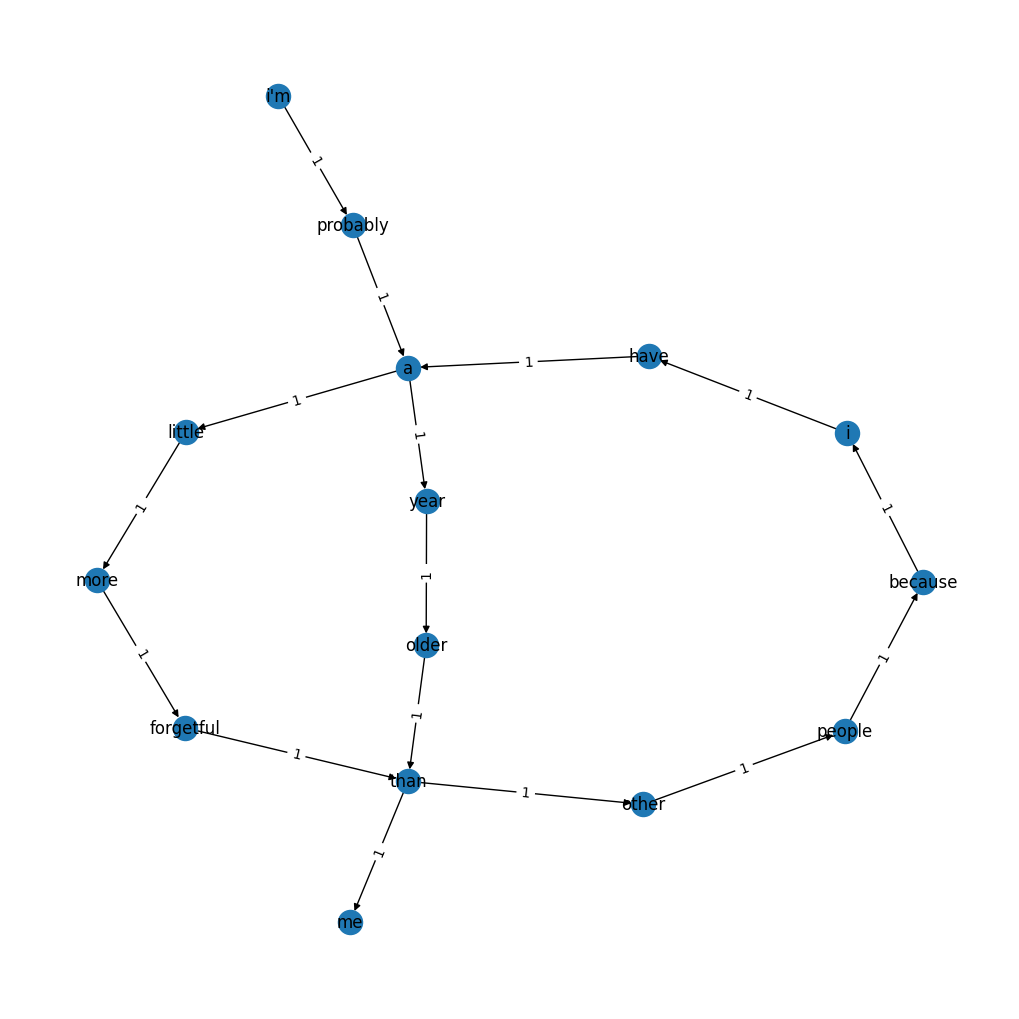

In [6]:
# an example:
text = "i'm probably a little more forgetful than other people because i have a year older than me."

g = build_weighted_digraph(text)
n = g.number_of_nodes()
e = g.number_of_edges()
l = len(list(nx.simple_cycles(g)))
print(text, "nodes:", n, "edges:", e,"loops:", l)
plot_graph(g)

#### undirected, unweighted graph

In [8]:
# Undirected, unweighted graph
avg_number_nodes = []
min_number_nodes = []
max_number_nodes = []
stdv_number_nodes = []
avg_number_edges = []
min_number_edges = []
max_number_edges = []
stdv_number_edges = []
avg_number_loops = []
min_number_loops = []
max_number_loops = []
stdv_number_loops = []

avg_number_nodes_divtokens = []
min_number_nodes_divtokens = []
max_number_nodes_divtokens = []
stdv_number_nodes_divtokens = []
avg_number_edges_divtokens = []
min_number_edges_divtokens = []
max_number_edges_divtokens = []
stdv_number_edges_divtokens = []
avg_number_loops_divtokens = []
min_number_loops_divtokens = []
max_number_loops_divtokens = []
stdv_number_loops_divtokens = []

for utterance in free_speech.TRANSCRIPT:
    
    all_utterances = utterance.lower()
    
    sentences = sent_tokenize(all_utterances)
    
    nodes = []
    edges = []
    loops = []
    nodes_divtokens = []
    edges_divtokens = []
    loops_divtokens = []
    
    for text in sentences:
        if len(text.split()) > 2:
            g = build_undirected_graph(text)
            n = g.number_of_nodes()
            e = g.number_of_edges()
            l = len(nx.cycle_basis(g))
            nodes.append(n)
            edges.append(e)
            loops.append(l)
            nodes_divtokens.append(n/len(text.split()))
            edges_divtokens.append(e/len(text.split()))
            loops_divtokens.append(l/len(text.split()))
     
    avg_number_nodes.append(np.array(nodes).mean())
    min_number_nodes.append(min(nodes))
    max_number_nodes.append(max(nodes))
    stdv_number_nodes.append(np.array(nodes).std())
    avg_number_edges.append(np.array(edges).mean())
    min_number_edges.append(min(edges))
    max_number_edges.append(max(edges))
    stdv_number_edges.append(np.array(edges).std())
    avg_number_loops.append(np.array(loops).mean())
    min_number_loops.append(min(loops))
    max_number_loops.append(max(loops))
    stdv_number_loops.append(np.array(loops).std())
    
    avg_number_nodes_divtokens.append(np.array(nodes_divtokens).mean())
    min_number_nodes_divtokens.append(min(nodes_divtokens))
    max_number_nodes_divtokens.append(max(nodes_divtokens))
    stdv_number_nodes_divtokens.append(np.array(nodes_divtokens).std())
    avg_number_edges_divtokens.append(np.array(edges_divtokens).mean())
    min_number_edges_divtokens.append(min(edges_divtokens))
    max_number_edges_divtokens.append(max(edges_divtokens))
    stdv_number_edges_divtokens.append(np.array(edges_divtokens).std())
    avg_number_loops_divtokens.append(np.array(loops_divtokens).mean())
    min_number_loops_divtokens.append(min(loops_divtokens))
    max_number_loops_divtokens.append(max(loops_divtokens))
    stdv_number_loops_divtokens.append(np.array(loops_divtokens).std())

free_speech['undirected_graph_nodes_average'] = avg_number_nodes
free_speech['undirected_graph_nodes_minimum'] = min_number_nodes
free_speech['undirected_graph_nodes_maximum'] = max_number_nodes
free_speech['undirected_graph_nodes_stdv'] = stdv_number_nodes
free_speech['undirected_graph_edges_average'] = avg_number_edges
free_speech['undirected_graph_edges_minimum'] = min_number_edges
free_speech['undirected_graph_edges_maximum'] = max_number_edges
free_speech['undirected_graph_edges_stdv'] = stdv_number_edges
free_speech['undirected_graph_loops_average'] = avg_number_loops
free_speech['undirected_graph_loops_minimum'] = min_number_loops
free_speech['undirected_graph_loops_maximum'] = max_number_loops
free_speech['undirected_graph_loops_stdv'] = stdv_number_loops

free_speech['undirected_graph_nodes_divtokens_average'] = avg_number_nodes_divtokens
free_speech['undirected_graph_nodes_divtokens_minimum'] = min_number_nodes_divtokens
free_speech['undirected_graph_nodes_divtokens_maximum'] = max_number_nodes_divtokens
free_speech['undirected_graph_nodes_divtokens_stdv'] = stdv_number_nodes_divtokens
free_speech['undirected_graph_edges_divtokens_average'] = avg_number_edges_divtokens
free_speech['undirected_graph_edges_divtokens_minimum'] = min_number_edges_divtokens
free_speech['undirected_graph_edges_divtokens_maximum'] = max_number_edges_divtokens
free_speech['undirected_graph_edges_divtokens_stdv'] = stdv_number_edges_divtokens
free_speech['undirected_graph_loops_divtokens_average'] = avg_number_loops_divtokens
free_speech['undirected_graph_loops_divtokens_minimum'] = min_number_loops_divtokens
free_speech['undirected_graph_loops_divtokens_maximum'] = max_number_loops_divtokens
free_speech['undirected_graph_loops_divtokens_stdv'] = stdv_number_loops_divtokens

#### directed, unweighted graph

In [14]:
# Directed, unweighted graph

avg_number_nodes = []
min_number_nodes = []
max_number_nodes = []
stdv_number_nodes = []
avg_number_edges = []
min_number_edges = []
max_number_edges = []
stdv_number_edges = []
avg_number_loops = []
min_number_loops = []
max_number_loops = []
stdv_number_loops = []

avg_number_nodes_divtokens = []
min_number_nodes_divtokens = []
max_number_nodes_divtokens = []
stdv_number_nodes_divtokens = []
avg_number_edges_divtokens = []
min_number_edges_divtokens = []
max_number_edges_divtokens = []
stdv_number_edges_divtokens = []
avg_number_loops_divtokens = []
min_number_loops_divtokens = []
max_number_loops_divtokens = []
stdv_number_loops_divtokens = []

for utterance in free_speech.TRANSCRIPT:
    
    all_utterances = utterance.lower()
    
    sentences = sent_tokenize(all_utterances)
    
    nodes = []
    edges = []
    loops = []
    nodes_divtokens = []
    edges_divtokens = []
    loops_divtokens = []
    
    for text in sentences:
        if len(text.split()) > 2:
            g = build_directed_graph(text)
            n = g.number_of_nodes()
            e = g.number_of_edges()
            l = len(list(nx.simple_cycles(g)))
            nodes.append(n)
            edges.append(e)
            loops.append(l)
            nodes_divtokens.append(n/len(text.split()))
            edges_divtokens.append(e/len(text.split()))
            loops_divtokens.append(l/len(text.split()))
            
    avg_number_nodes.append(np.array(nodes).mean())
    min_number_nodes.append(min(nodes))
    max_number_nodes.append(max(nodes))
    stdv_number_nodes.append(np.array(nodes).std())
    avg_number_edges.append(np.array(edges).mean())
    min_number_edges.append(min(edges))
    max_number_edges.append(max(edges))
    stdv_number_edges.append(np.array(edges).std())
    avg_number_loops.append(np.array(loops).mean())
    min_number_loops.append(min(loops))
    max_number_loops.append(max(loops))
    stdv_number_loops.append(np.array(loops).std())
    
    avg_number_nodes_divtokens.append(np.array(nodes_divtokens).mean())
    min_number_nodes_divtokens.append(min(nodes_divtokens))
    max_number_nodes_divtokens.append(max(nodes_divtokens))
    stdv_number_nodes_divtokens.append(np.array(nodes_divtokens).std())
    avg_number_edges_divtokens.append(np.array(edges_divtokens).mean())
    min_number_edges_divtokens.append(min(edges_divtokens))
    max_number_edges_divtokens.append(max(edges_divtokens))
    stdv_number_edges_divtokens.append(np.array(edges_divtokens).std())
    avg_number_loops_divtokens.append(np.array(loops_divtokens).mean())
    min_number_loops_divtokens.append(min(loops_divtokens))
    max_number_loops_divtokens.append(max(loops_divtokens))
    stdv_number_loops_divtokens.append(np.array(loops_divtokens).std())

free_speech['directed_graph_nodes_average'] = avg_number_nodes
free_speech['directed_graph_nodes_minimum'] = min_number_nodes
free_speech['directed_graph_nodes_maximum'] = max_number_nodes
free_speech['directed_graph_nodes_stdv'] = stdv_number_nodes
free_speech['directed_graph_edges_average'] = avg_number_edges
free_speech['directed_graph_edges_minimum'] = min_number_edges
free_speech['directed_graph_edges_maximum'] = max_number_edges
free_speech['directed_graph_edges_stdv'] = stdv_number_edges
free_speech['directed_graph_loops_average'] = avg_number_loops
free_speech['directed_graph_loops_minimum'] = min_number_loops
free_speech['directed_graph_loops_maximum'] = max_number_loops
free_speech['directed_graph_loops_stdv'] = stdv_number_loops

free_speech['directed_graph_nodes_divtokens_average'] = avg_number_nodes_divtokens
free_speech['directed_graph_nodes_divtokens_minimum'] = min_number_nodes_divtokens
free_speech['directed_graph_nodes_divtokens_maximum'] = max_number_nodes_divtokens
free_speech['directed_graph_nodes_divtokens_stdv'] = stdv_number_nodes_divtokens
free_speech['directed_graph_edges_divtokens_average'] = avg_number_edges_divtokens
free_speech['directed_graph_edges_divtokens_minimum'] = min_number_edges_divtokens
free_speech['directed_graph_edges_divtokens_maximum'] = max_number_edges_divtokens
free_speech['directed_graph_edges_divtokens_stdv'] = stdv_number_edges_divtokens
free_speech['directed_graph_loops_divtokens_average'] = avg_number_loops_divtokens
free_speech['directed_graph_loops_divtokens_minimum'] = min_number_loops_divtokens
free_speech['directed_graph_loops_divtokens_maximum'] = max_number_loops_divtokens
free_speech['directed_graph_loops_divtokens_stdv'] = stdv_number_loops_divtokens

#### directed, weighted graph

In [15]:
# directed, weighted graph

avg_avg_weights = []
min_avg_weights = []
max_avg_weights = []
stdv_avg_weights = []

avg_min_weights = []
min_min_weights = []
max_min_weights = []
stdv_min_weights = []

avg_max_weights = []
min_max_weights = []
max_max_weights = []
stdv_max_weights = []

avg_stdv_weights = []
min_stdv_weights = []
max_stdv_weights = []
stdv_stdv_weights = []

for utterance in free_speech.TRANSCRIPT:
    
    all_utterances = utterance.lower()
    
    sentences = sent_tokenize(all_utterances)
    
    avg_weights = []
    min_weights = []
    max_weights = []
    stdv_weights = []
    
    # for sentence in each utterance
    for text in sentences:
        if len(text.split()) > 2:
            g = build_weighted_digraph(text)
            
            weights = []
            for x in g.edges(data=True):
                weights.append(x[2]['weight'])

            avg_weights.append(np.array(weights).mean())
            min_weights.append(min(weights))
            max_weights.append(max(weights))
            stdv_weights.append(np.array(weights).std())
            
    avg_avg_weights.append(np.array(avg_weights).mean())
    min_avg_weights.append(min(avg_weights))
    max_avg_weights.append(max(avg_weights))
    stdv_avg_weights.append(np.array(avg_weights).std())
    
    avg_min_weights.append(np.array(min_weights).mean())
    min_min_weights.append(min(min_weights))
    max_min_weights.append(max(min_weights))
    stdv_min_weights.append(np.array(min_weights).std())
    
    avg_max_weights.append(np.array(max_weights).mean())
    min_max_weights.append(min(max_weights))
    max_max_weights.append(max(max_weights))
    stdv_max_weights.append(np.array(max_weights).std())
    
    avg_stdv_weights.append(np.array(stdv_weights).mean())
    min_stdv_weights.append(min(stdv_weights))
    max_stdv_weights.append(max(stdv_weights))
    stdv_stdv_weights.append(np.array(stdv_weights).std())
    
free_speech['weighted_directed_graph_avg_weights_average'] = avg_avg_weights
free_speech['weighted_directed_graph_avg_weights_minimum'] = min_avg_weights
free_speech['weighted_directed_graph_avg_weights_maximum'] = max_avg_weights
free_speech['weighted_directed_graph_avg_weights_stdv'] = stdv_avg_weights

free_speech['weighted_directed_graph_min_weights_average'] = avg_min_weights
free_speech['weighted_directed_graph_min_weights_minimum'] = min_min_weights
free_speech['weighted_directed_graph_min_weights_maximum'] = max_min_weights
free_speech['weighted_directed_graph_min_weights_stdv'] = stdv_min_weights

free_speech['weighted_directed_graph_max_weights_average'] = avg_max_weights
free_speech['weighted_directed_graph_max_weights_minimum'] = min_max_weights
free_speech['weighted_directed_graph_max_weights_maximum'] = max_max_weights
free_speech['weighted_directed_graph_max_weights_stdv'] = stdv_max_weights

free_speech['weighted_directed_graph_stdv_weights_average'] = avg_stdv_weights
free_speech['weighted_directed_graph_stdv_weights_minimum'] = min_stdv_weights
free_speech['weighted_directed_graph_stdv_weights_maximum'] = max_stdv_weights
free_speech['weighted_directed_graph_stdv_weights_stdv'] = stdv_stdv_weights

In [16]:
free_speech.to_excel('Free_Speech_Features_Final.xlsx')

In [20]:
free_speech = free_speech.rename(columns={'diagnosis':'GROUP'})

In [22]:
free_speech = free_speech.drop(columns=['Unnamed: 0.1', 'Unnamed: 0'])

In [29]:
free_speech['GROUP'].unique()

array(['AD', 'aMCI', 'HC'], dtype=object)

# Computing the f statistics for individual features

In [ ]:
for column in free_speech.columns:
    
    if column != 'FILE' and column != 'TRANSCRIPT' and column != 'GROUP' and column != 'participant_parse_depth_per_sentence':
        
        ones = free_speech[free_speech.GROUP=='HC']
        twos = free_speech[free_speech.GROUP=='aMCI']
        threes = free_speech[free_speech.GROUP=='AD']
        twosthrees = free_speech[(free_speech.GROUP=='aMCI')|(free_speech.GROUP=='AD')]
        
        f1, p1 = stats.f_oneway(ones[column].dropna(), twos[column].dropna(), threes[column].dropna())
        f2, p2 = stats.f_oneway(ones[column].dropna(), twos[column].dropna())
        f3, p3 = stats.f_oneway(ones[column].dropna(), threes[column].dropna())
        f4, p4 = stats.f_oneway(twos[column].dropna(), threes[column].dropna())
        f5, p5 = stats.f_oneway(ones[column].dropna(), twosthrees[column].dropna())

        print(column, 'overall', (f1,p1), '1vs2', (f2,p2),'1vs3', (f3,p3),'2vs3', (f4,p4), '1vs23', (f5,p5))
        